In [1]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
import os

app_dir = os.path.join(os.getcwd(), "app")
load_dotenv(os.path.join(app_dir, ".env"))

loader = DirectoryLoader("./data", glob="**/*.txt")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=350,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
chunks = text_splitter.split_documents(docs)

In [2]:
chunks[0]

Document(page_content='margherita pizza; $12; classic with tomato, mozzarella, and basil; main dish\n\nspaghetti carbonara; $15; creamy pasta with pancetta and parmesan; main dish\n\nbruschetta; $8; toasted bread with tomato, garlic, and olive oil; appetizer\n\ncaprese salad; $10; fresh tomatoes, mozzarella, and basil; salad', metadata={'source': 'data\\food.txt'})

In [3]:
# RAGAS expects a file_name dict as key
for document in chunks:
    document.metadata["file_name"] = document.metadata["source"]

In [4]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

embeddings = OpenAIEmbeddings()
model = ChatOpenAI()

generator = TestsetGenerator.from_langchain(
    embeddings=embeddings, generator_llm=model, critic_llm=model
)

testset = generator.generate_with_langchain_docs(
    chunks,
    test_size=8,
    distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25},
)

c:\Users\Axioo Pongo\Documents\GitHub\Udemy-Advanced-LangChain\.lc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Filename and doc_id are the same for all nodes.                 
Generating: 100%|██████████| 8/8 [00:59<00:00,  7.42s/it]


In [5]:
testset.to_pandas()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How did Amico's Nonna influence his passion fo...,[Amico's life was deeply entwined with the vib...,Amico's Nonna influenced his passion for cooki...,simple,"[{'source': 'data\founder.txt', 'file_name': '...",True
1,What is the significance of Amico's legacy bey...,[Amico’s legacy is not just in the dishes he c...,Amico's legacy goes beyond the dishes he creat...,simple,"[{'source': 'data\founder.txt', 'file_name': '...",True
2,How has Chef Amico's lifetime of love influenc...,[Amico’s legacy is not just in the dishes he c...,Chef Amico's lifetime of love has influenced h...,simple,"[{'source': 'data\founder.txt', 'file_name': '...",True
3,How has Chef Amico's lifetime of love influenc...,[Amico’s legacy is not just in the dishes he c...,Chef Amico's lifetime of love has influenced h...,simple,"[{'source': 'data\founder.txt', 'file_name': '...",True
4,How did Nonna Lucia's kitchen influence Amico'...,"[In the heart of the old quarter of Palermo, a...",Nonna Lucia's kitchen influenced Amico's relat...,multi_context,"[{'source': 'data\founder.txt', 'file_name': '...",True
5,How does Chef Amico blend culinary art with cr...,[Amico’s legacy is not just in the dishes he c...,Chef Amico blends culinary art with creating a...,multi_context,"[{'source': 'data\founder.txt', 'file_name': '...",True


In [6]:
from langchain_openai.embeddings import OpenAIEmbeddings

from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI

embedding = OpenAIEmbeddings()
model = ChatOpenAI()

vectorstore = Chroma.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [7]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [8]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [9]:
# questions = testset.to_pandas()["question"].to_list()
# ground_truth = testset.to_pandas()["ground_truth"].to_list()

import pandas as pd

df = pd.read_csv("./questions_answers/qa.csv", delimiter=";")
questions = df["question"].tolist()
ground_truth = df["ground_truth"].tolist()

In [10]:
ground_truth

['Amico was born in the heart of the old quarter of Palermo.',
 "Amico was influenced by the cooking in his Nonna Lucia's kitchen.",
 "Amico learned to select the freshest fish and ripest fruits from Palermo's markets.",
 'Amico gained culinary experience across various regions in Italy, including Tuscany and Venice.',
 'Chef Amico is known for combining Sicilian and modern Italian cuisine.',
 "The menu reflects Amico's culinary journey and commitment to excellence.",
 "Amico sees hospitality as an art of celebrating life's simple pleasures.",
 "Chef Amico is distinguished by Amico's dedication and the community he nurtures.",
 'Amico mentors young chefs, conducts culinary workshops, and supports local producers.',
 "Amico's legacy lies in his community involvement and passion for food.",
 'Chef Amico is set in a quaint alley in Palermo.',
 'Chef Amico has a welcoming atmosphere with aromatic garlic and olive oil.',
 "The walls showcase Amico's travels and family recipes, representing 

In [11]:
from datasets import Dataset

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(rag_chain.invoke(query))
    data["contexts"].append(
        [doc.page_content for doc in retriever.invoke(query)]
    )

dataset = Dataset.from_dict(data)

In [12]:
first_entry = {
    "question": data["question"][0],
    "answer": data["answer"][0],
    "contexts": data["contexts"][0],
    "ground_truth": data["ground_truth"][0],
}
first_entry

{'question': 'Where was Amico born?',
 'answer': 'Amico was born in Sicily.',
 'contexts': ['From a young age, Amico was immersed in the art of Sicilian cooking. His days were punctuated by visits to the bustling markets of Palermo, where he learned to choose the freshest fish from the Mediterranean and the ripest fruits kissed by the Sicilian sun. These experiences not only sharpened his culinary skills but also deepened his respect for',
  "Amico's life was deeply entwined with the vibrant essence of Sicilian cuisine. In the rustic kitchen where his Nonna conjured culinary magic, Amico found his calling. These formative years, filled with the rhythmic chopping of fresh herbs and the sizzling of rich tomato sauces, laid the foundation of his passion for cooking.",
  'The Journey to Chef Amico',
  'As he grew, so did his desire to explore beyond the shores of Sicily. Venturing through Italy, Amico worked alongside renowned chefs, each teaching him a new facet of Italian cuisine. From t

In [13]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset=dataset,
    metrics=[
        context_relevancy,
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    llm=model,
    embeddings=embedding
)

Evaluating: 100%|██████████| 150/150 [01:02<00:00,  2.41it/s]


In [14]:
result.to_pandas()

,question,answer,contexts,ground_truth,context_relevancy,context_precision,context_recall,faithfulness,answer_relevancy
0,Where was Amico born?,Amico was born in Sicily.,"[From a young age, Amico was immersed in the a...",Amico was born in the heart of the old quarter...,0.100000,0.833333,0.0,0.000000,1.000000
1,What was Amico's early culinary influence?,Amico's early culinary influence was Sicilian ...,"[From a young age, Amico was immersed in the a...",Amico was influenced by the cooking in his Non...,0.166667,1.000000,1.0,1.000000,0.998192
2,What skill did Amico learn from Palermo's mark...,Amico learned to choose the freshest fish from...,"[From a young age, Amico was immersed in the a...",Amico learned to select the freshest fish and ...,0.181818,1.000000,1.0,1.000000,0.966085
3,Where in Italy did Amico gain culinary experie...,Amico gained culinary experience in various re...,"[As he grew, so did his desire to explore beyo...",Amico gained culinary experience across variou...,0.100000,0.750000,1.0,0.666667,0.979475
4,"What is ""Chef Amico"" restaurant known for?",Chef Amico restaurant is known for serving a t...,"[Creating Chef Amico’s Restaurant, At Chef Ami...",Chef Amico is known for combining Sicilian and...,0.142857,1.000000,1.0,1.000000,0.990710
5,What does Amico's restaurant menu reflect?,Amico's restaurant menu reflects a tapestry of...,"[At Chef Amico, every dish told a story. The m...",The menu reflects Amico's culinary journey and...,0.090909,1.000000,1.0,1.000000,1.000000
6,How does Amico perceive hospitality?,"Amico perceives hospitality as an art form, a ...","[For Amico, hospitality was an art form. He be...",Amico sees hospitality as an art of celebratin...,0.272727,1.000000,1.0,1.000000,1.000000
7,"What distinguishes ""Chef Amico"" in Palermo?","""Chef Amico"" in Palermo is distinguished by it...","[Returning to Palermo with a vision, Amico ope...",Chef Amico is distinguished by Amico's dedicat...,0.090909,1.000000,1.0,0.500000,0.976273
8,What activities does Amico engage in besides c...,Amico also engages in visiting bustling market...,"[From a young age, Amico was immersed in the a...","Amico mentors young chefs, conducts culinary w...",0.100000,0.805556,0.0,0.666667,0.922216
9,How is Amico's legacy beyond his dishes?,Amico's legacy extends beyond his dishes throu...,[Amico’s legacy is not just in the dishes he c...,Amico's legacy lies in his community involveme...,0.230769,1.000000,1.0,1.000000,0.956800


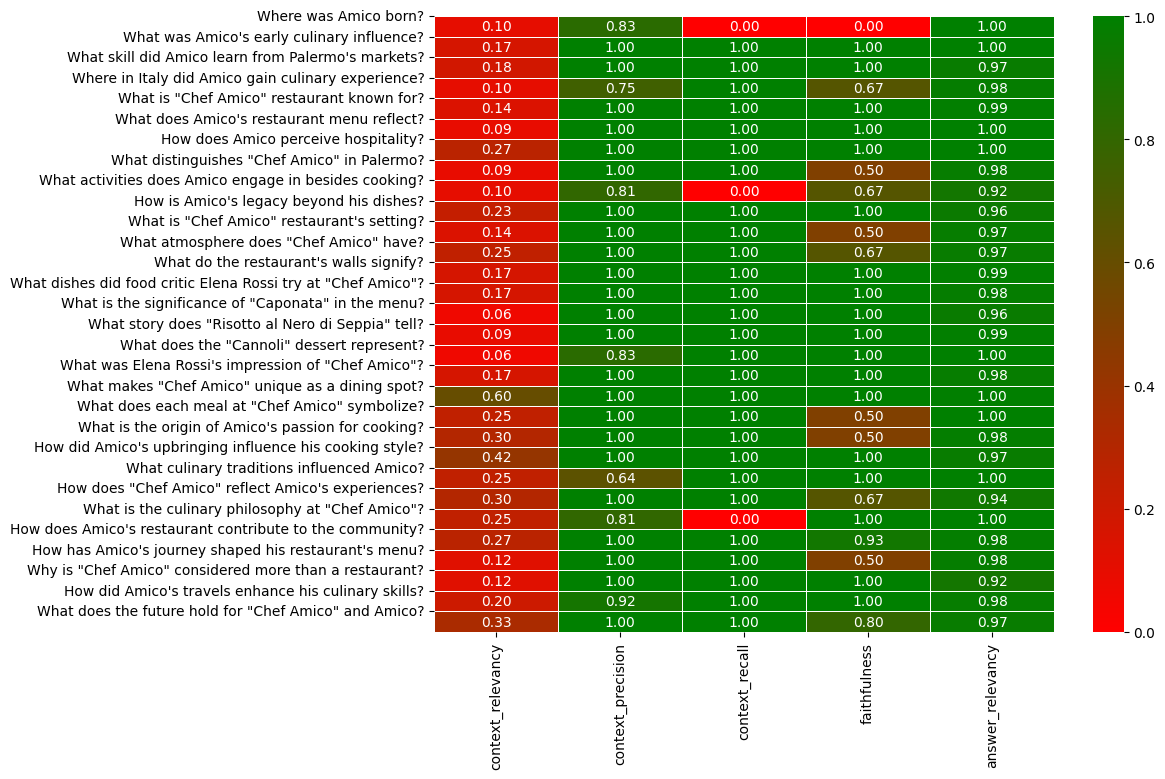

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[
    [
        "context_relevancy",
        "context_precision",
        "context_recall",
        "faithfulness",
        "answer_relevancy",
    ]
]

cmap = LinearSegmentedColormap.from_list("green_red", ["red", "green"])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=0.5, cmap=cmap)

plt.yticks(ticks=range(len(df["question"])), labels=df["question"], rotation=0)

plt.show()